In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import ipdb
import wandb
import datetime
from wandb.keras import WandbCallback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN
from keras.models import Sequential
from IPython.display import Image, display
print("Using tensorflow:",tf.__version__)

Using tensorflow: 2.4.1


In [33]:
wandb.init(project='Assignment 3', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')
wandb.run.name = "LSTM-Transliteration-" + datetime.datetime.now().isoformat()
wandb.run.save()

epoch,49
loss,0.01997
accuracy,0.99371
val_loss,0.2916
val_accuracy,0.93998
_runtime,578
_timestamp,1619797744
_step,49
best_val_loss,0.19149
best_epoch,11


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇▇████████████████████████████
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_accuracy,▁▄▆▇▇███████████████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/DL-A3 Dataset'
# %%capture
# !curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dataset.tar
# !tar -xvf dataset.tar
# !rm dataset.tar
# %cd 'dakshina_dataset_v1.0/hi/lexicons'

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preparing the data

In [41]:
val_df = pd.read_csv("./lexicons/hi.translit.sampled.dev.tsv", sep='\t', header=None)
train_df = pd.read_csv("./lexicons/hi.translit.sampled.train.tsv", sep='\t', header=None)
test_df = pd.read_csv("./lexicons/hi.translit.sampled.test.tsv", sep='\t', header=None)

In [42]:
def process_dataframe(data):
    input_words = []
    target_words = []
    input_characters = set()
    target_characters = set()
    for x, y in zip(data[1], data[0]):
        x = str(x)
        y = str(y)
        # Add words to respective lists
        input_words.append(x)
        target_words.append("\t" + y + "\n")
        # Add characters to set
        for ch in x:
            if ch not in input_characters:
                input_characters.add(ch)
        for ch in y:
            if ch not in target_characters:
                target_characters.add(ch)
    return input_words, target_words, input_characters, target_characters

In [43]:
def get_all_words(data_list: list):
    words = set()
    for data in data_list:
        words.update(data)
    return words

In [44]:
val_input_words, val_target_words, val_input_characters, val_target_characters = process_dataframe(val_df)
train_input_words, train_target_words, train_input_characters, train_target_characters = process_dataframe(train_df)    
test_input_words, test_target_words, test_input_characters, test_target_characters = process_dataframe(test_df)    

In [45]:
input_characters = val_input_characters.union(train_input_characters, test_input_characters, [" "])
target_characters = val_target_characters.union(train_target_characters, test_target_characters, [" ","\t", "\n"])

In [46]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

all_input_words = get_all_words([val_input_words, train_input_words, test_input_words])
all_target_words = get_all_words([val_target_words, train_target_words, test_target_words])

max_encoder_seq_length = max([len(txt) for txt in all_input_words])
max_decoder_seq_length = max([len(txt) for txt in all_target_words])

In [47]:
print(f"Number of Training samples: {len(train_input_words)} | Number of Validation samples: {len(val_input_words)} | Number of Test samples: {len(test_input_words)}")
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of Training samples: 44204 | Number of Validation samples: 4358 | Number of Test samples: 4502
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [48]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [49]:
def prepare_data(input_words, target_words, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length):
    encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
    decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
    decoder_target_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

    for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
        # Input Data
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.0
        encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
        # Target Data
        for t, char in enumerate(target_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[char]] = 1.0
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
        decoder_target_data[i, t:, target_token_index[" "]] = 1.0
        
    # Return Data
    return encoder_input_data, decoder_input_data, decoder_target_data

In [50]:
# Validation Data
val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = prepare_data(val_input_words, val_target_words, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)
# Training Data
train_encoder_input_data, train_decoder_input_data, train_decoder_target_data = prepare_data(train_input_words, train_target_words, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)
# Test Data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = prepare_data(test_input_words, test_target_words, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

## Configuration

In [51]:
batch_size = 64  # Batch size for training.
epochs = 1  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

## Building the model

In [52]:
LSTM_LAYER = "LSTM"
GRU_LAYER = "GRU"
SIMPLE_RNN_LAYER = "SIMPLE_RNN"

In [53]:
def get_model(embedding_size, num_encoder_layers, num_decoder_layers, hidden_layer_size, layer_type, dropout, num_encoder_tokens, num_decoder_tokens):
    
    encoder_inputs = keras.Input(shape=(None,))
    encoder = Embedding(input_dim = num_encoder_tokens, output_dim = embedding_size)(encoder_inputs)
    
    decoder_inputs = keras.Input(shape=(None,))
    decoder = Embedding(input_dim = num_decoder_tokens, output_dim = embedding_size)(decoder_inputs)
    
    # Add Memory Layers
    if layer_type == LSTM_LAYER:
        # ENCODER ================================================================================================

        # Add LSTM layers
        for i in range(num_encoder_layers-1):
            encoder = LSTM(hidden_layer_size, return_state = True, return_sequences = True, dropout = dropout, name = 'encoder_'+str(i+1))(encoder)
        
        # Last LSTM Layer, Encoder outputs will act as decoder initial states    
        encoder_outputs, state_h, state_c = LSTM(hidden_layer_size, return_state = True, return_sequences = False, dropout = dropout, name = 'encoder_'+str(num_encoder_layers))(encoder)
        
        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]
        
        # ========================================================================================================

        # DECODER ================================================================================================
        
        # First LSTM Layer, Encoder final state will act as decoder initial state    
        decoder = LSTM(hidden_layer_size, return_state = True, return_sequences = True, dropout = dropout, name = 'decoder_1')(decoder, initial_state = encoder_states)
        
        # Add LSTM layers
        for i in range(num_decoder_layers-1):
            decoder = LSTM(hidden_layer_size, return_state = True, return_sequences = True, dropout = dropout, name = 'decoder_'+str(i+2))(decoder)
        
        decoder_outputs, _, _ = decoder
        
        # ========================================================================================================
        
    elif layer_type == GRU_LAYER:
        # ENCODER ================================================================================================
        
        # Add GRU Layers
        for i in range(num_encoder_layers - 1):
            encoder = GRU(hidden_layer_size, return_state = True, return_sequences = True, dropout = dropout, name = 'encoder_'+str(i+1))(encoder)

        # Last GRU Layer, Encoder outputs will act as decoder initial states
        encoder_outputs, state_c = GRU(hidden_layer_size, return_state = True, dropout = dropout, name = 'encoder_'+str(num_encoder_layers))(encoder)

        # We discard `encoder_outputs` and only keep the state.
        encoder_states = [state_c]
        
        # ========================================================================================================
        
        # DECODER ================================================================================================

        # First GRU Layer, Encoder final state will act as decoder initial state   
        decoder = GRU(hidden_layer_size, return_sequences=True, return_state=True,dropout=dropout, name = 'decoder_1')(decoder, initial_state = encoder_states)
        
        # Add GRU layers
        for i in range(num_decoder_layers-1):
            decoder = GRU(hidden_layer_size, return_sequences=True, return_state=True,dropout=dropout, name = 'decoder_'+str(i+2))(decoder)

        decoder_outputs, _ = decoder
        
        # ========================================================================================================
        
    else:
        # ENCODER ================================================================================================
        
        # Add SimpleRNN Layers
        for i in range(num_encoder_layers-1):
            encoder = SimpleRNN(hidden_layer_size, return_state = True, return_sequences = True, dropout = dropout, name = 'encoder_'+str(i+1))(encoder)

        # Last SimpleRNN Layer, Encoder outputs will act as decoder initial states
        encoder_outputs, state_c = SimpleRNN(hidden_layer_size, return_state = True, dropout = dropout, name = 'encoder_'+str(num_encoder_layers))(encoder)

        # We discard `encoder_outputs` and only keep the state.
        encoder_states = [state_c]

        # ========================================================================================================
        
        # DECODER ================================================================================================

        # First GRU Layer, Encoder final state will act as decoder initial state   
        decoder = SimpleRNN(hidden_layer_size, return_sequences = True, return_state = True, dropout = dropout, name = 'decoder_1')(decoder, initial_state = encoder_states)
        
        # Add SimpleRNN Layers
        for i in range(num_decoder_layers-1):
            decoder = SimpleRNN(hidden_layer_size, return_sequences=True, return_state=True,dropout=dropout, name = 'decoder_'+str(i+2))(decoder)

        decoder_outputs, _ = decoder
        
        # ========================================================================================================
        
    decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model

## Training the model

In [61]:
model = get_model(16, 2, 2, 16, LSTM_LAYER, 0.2, num_encoder_tokens, num_decoder_tokens)
model.compile(optimizer="nadam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 16)     432         input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_1 (LSTM)                [(None, None, 16), ( 2112        embedding_10[0][0]               
____________________________________________________________________________________________

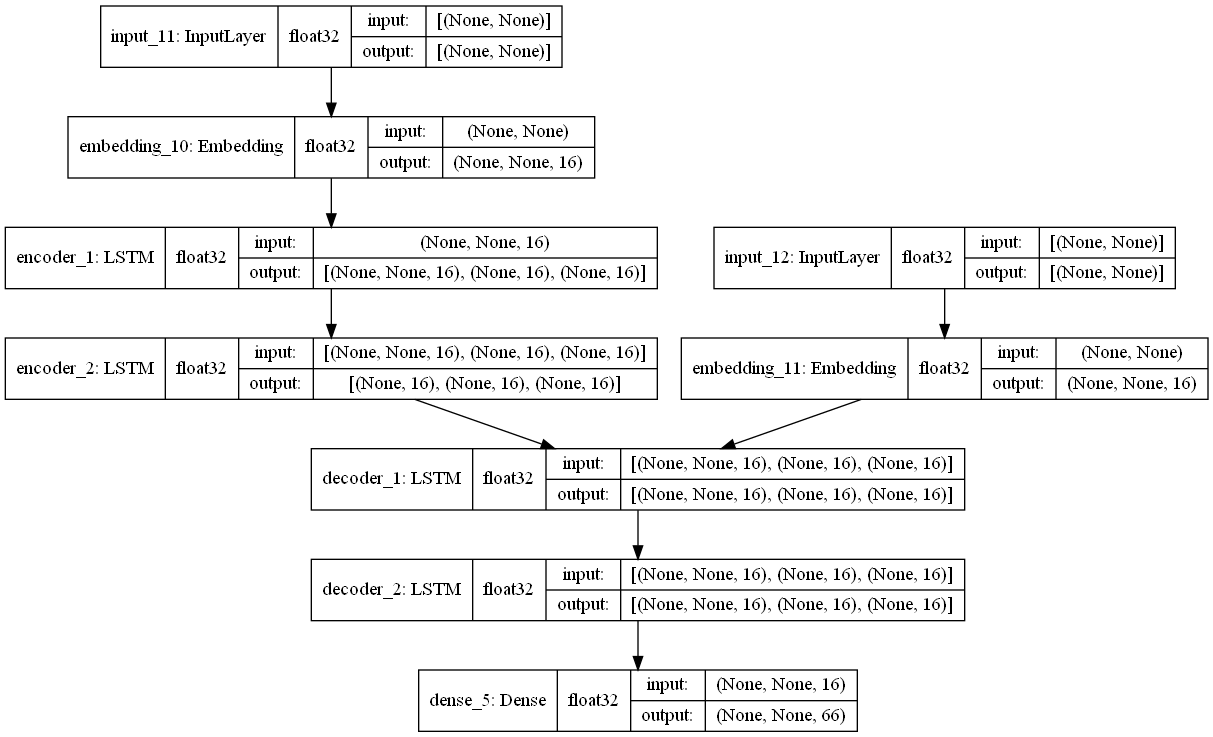

In [62]:
keras.utils.plot_model(
    model, 
    to_file=f"model-{str(datetime.datetime.now().isoformat()).replace('.','').replace(':','')}.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True
)

In [64]:
model.fit(
    [train_encoder_input_data, train_decoder_input_data],
    train_decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data),
#     callbacks=[WandbCallback()]
)


# Save the entire model
model.save('s2s')
model.save('s2s.h5',save_format='h5')

ValueError: in user code:

    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\shibo\.pyenv\pyenv-win\versions\3.8.8\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer encoder_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 20, 27, 16)


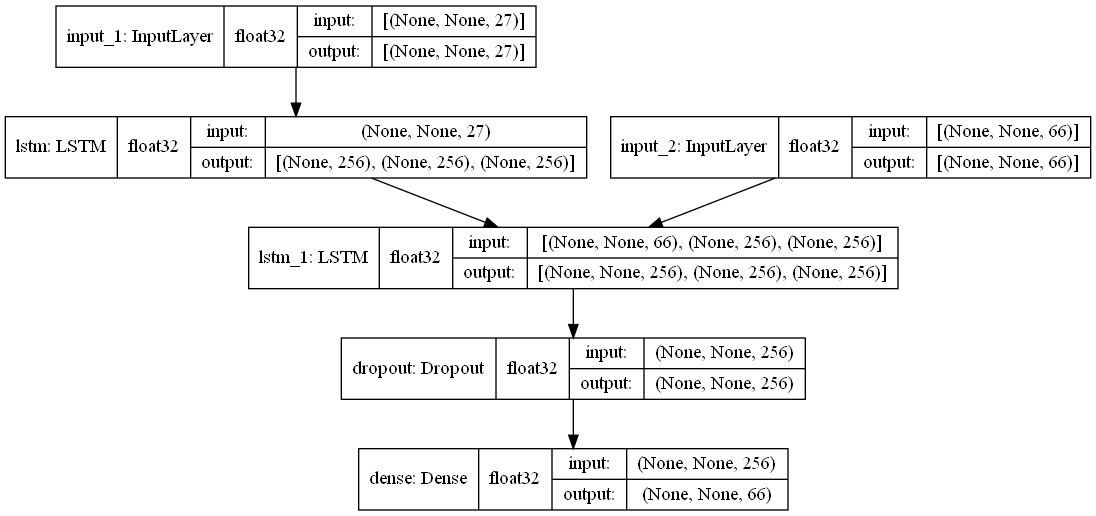

In [25]:
keras.utils.plot_model(
    model, 
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    expand_nested=True
)

## Running inference

In [20]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
saved_model = keras.models.load_model("saved_model\s2s")
saved_model.summary()

saved_encoder_inputs = saved_model.input[0]  # input_1
saved_encoder_outputs, state_h_enc, state_c_enc = saved_model.layers[2].output  # lstm_1
saved_encoder_states = [state_h_enc, state_c_enc]
saved_encoder_model = keras.Model(saved_encoder_inputs, saved_encoder_states)

saved_decoder_inputs = saved_model.input[1]  # input_2
saved_decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
saved_decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
saved_decoder_states_inputs = [saved_decoder_state_input_h, saved_decoder_state_input_c]
saved_decoder_lstm = saved_model.layers[3]

saved_decoder_outputs, saved_state_h_dec, saved_state_c_dec = saved_decoder_lstm(saved_decoder_inputs, initial_state=saved_decoder_states_inputs)
saved_decoder_states = [saved_state_h_dec, saved_state_c_dec]
saved_decoder_dense = saved_model.layers[4]
saved_decoder_outputs = saved_decoder_dense(saved_decoder_outputs)
saved_decoder_model = keras.Model([saved_decoder_inputs] + saved_decoder_states_inputs, [saved_decoder_outputs] + saved_decoder_states)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 27)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 290816      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  330752      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [21]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [22]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = saved_encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:
        output_tokens, h, c = saved_decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [31]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-"*80)
    print("Input sentence:", test_input_words[seq_index])
    print("Decoded sentence:", decoded_sentence)

--------------------------------------------------------------------------------
Input sentence: ank
Decoded sentence: अंक

--------------------------------------------------------------------------------
Input sentence: anka
Decoded sentence: अंका

--------------------------------------------------------------------------------
Input sentence: ankit
Decoded sentence: अनकित

--------------------------------------------------------------------------------
Input sentence: anakon
Decoded sentence: आंकों

--------------------------------------------------------------------------------
Input sentence: ankhon
Decoded sentence: अंखों

--------------------------------------------------------------------------------
Input sentence: ankon
Decoded sentence: अंकों

--------------------------------------------------------------------------------
Input sentence: angkor
Decoded sentence: अंगकर

--------------------------------------------------------------------------------
Input sentence: ankor
Deco